In [1]:
from nltk import word_tokenize
from nltk import sent_tokenize
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
import matplotlib.pyplot as plt
import keras.utils as ku 
import re
import numpy as np
import statistics
import pandas as pd

Using TensorFlow backend.


In [2]:
data = pd.read_json("7postElection.json")
data.drop(["favorite_count","retweet_count"],axis=1,inplace=True)

#prendi solo tweet suoi e no risposte
data = data[data["is_retweet"] == False]
data = data[data["in_reply_to_user_id_str"].isnull()]
print(len(data))

#data.drop(["is_retweet","in_reply_to_user_id_str"],axis=1,inplace=True)
data.reset_index(inplace=True,drop=True)


5783


In [3]:
for cluster in data["labels"].unique():
    print(cluster, len(data[data["labels"]==cluster]))

1 731
3 1760
2 495
5 908
0 469
6 672
4 748


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/menis/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


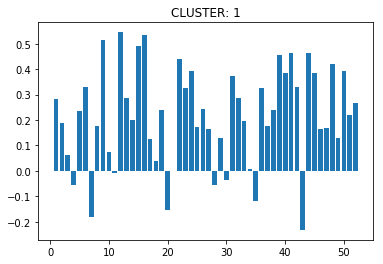

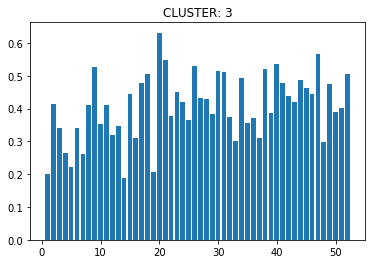

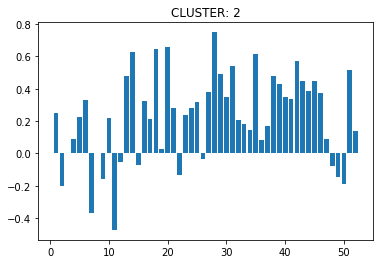

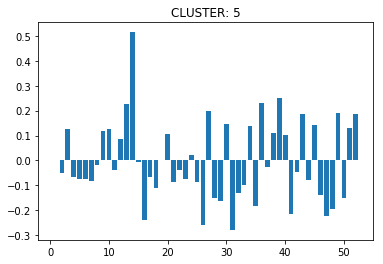

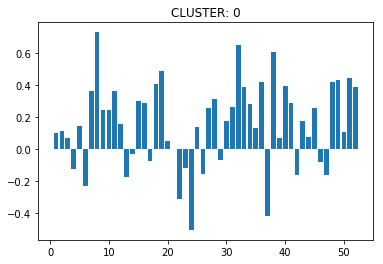

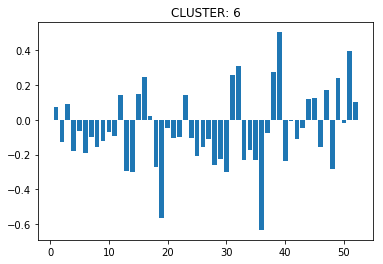

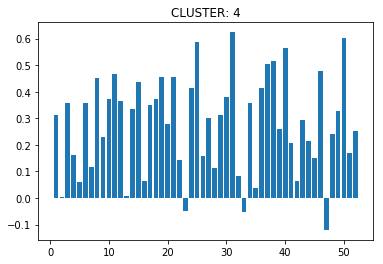

In [4]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
vader = SentimentIntensityAnalyzer()
text = data["text"].tolist()
scores = list()
positive = list()
negative = list()
neut = list()
for t in text:
    scores.append(vader.polarity_scores(t)['compound'])
    positive.append(vader.polarity_scores(t)['pos'])
    negative.append(vader.polarity_scores(t)['neg'])
    neut.append(vader.polarity_scores(t)['neu'])
data["vaderScore"] = scores

for cluster in data["labels"].unique():    
    time = data[data["labels"] == cluster]
    
    time = time.groupby(["week_year"])["vaderScore"].mean()
    plt.title("CLUSTER: " + str(cluster))
    plt.bar(time.index, time )
    plt.show()


In [5]:
#remove links
data["modded1"] = data["text"].str.replace("http\S+"," ")

data["modded1"] = data["text"].str.replace("\n", " ")

#remove punctuation
data['modded1'] = data["modded1"].str.replace("[^\w\s]"," ")
data["modded1"] = data["modded1"].str.lower()

In [6]:
sentences = data[data["labels"] == 5]["modded1"].tolist()
sentences1 = data[data["labels"]== 1]["modded1"].tolist()
sentences2 = data[data["labels"]== 0]["modded1"].tolist()
sentences3 = data[data["labels"]== 6]["modded1"].tolist()

sentences = sentences + sentences1 +sentences2 # +sentences3
#sentences = sentences[0:2500]
len(sentences)

2108

In [7]:
fullText = " ".join(sentences)
text_in_words = [w for w in fullText.split(' ') if w.strip() != '' or w == '\n']
text_in_words = list(map(lambda s: s.strip(), text_in_words))

print('Corpus length in words:', len(text_in_words))

from collections import Counter
word_freq = dict(Counter(fullText.split()))

not_freq = [x for x in word_freq if word_freq[x] < 4] 

shorter = []
for sentence in sentences:
    t = sentence.split()
    q = sentence
    for el in t:
        if el in not_freq:
            q = q.replace(el," ")
    if q != []:
        shorter.append([q])
        
unique = len(word_freq.keys())-len(not_freq)
print("words", len(word_freq.keys()))
print("not frequent", len(not_freq))
print("remaining", len(word_freq.keys())-len(not_freq))

Corpus length in words: 68102
words 7025
not frequent 5049
remaining 1976


In [8]:
text_in_words

['various',
 'media',
 'outlets',
 'and',
 'pundits',
 'say',
 'that',
 'i',
 'thought',
 'i',
 'was',
 'going',
 'to',
 'lose',
 'the',
 'election',
 'wrong',
 'it',
 'all',
 'came',
 'together',
 'in',
 'the',
 'last',
 'week',
 'and',
 'people',
 'must',
 'remember',
 'that',
 'obamacare',
 'just',
 'doesn',
 't',
 'work',
 'and',
 'it',
 'is',
 'not',
 'affordable',
 '116',
 'increases',
 'arizona',
 'bill',
 'clinton',
 'called',
 'it',
 'crazy',
 'there',
 'should',
 'be',
 'no',
 'further',
 'releases',
 'from',
 'gitmo',
 'these',
 'are',
 'extremely',
 'dangerous',
 'people',
 'and',
 'should',
 'not',
 'be',
 'allowed',
 'back',
 'onto',
 'the',
 'battlefield',
 'republicans',
 'must',
 'be',
 'careful',
 'in',
 'that',
 'the',
 'dems',
 'own',
 'the',
 'failed',
 'obamacare',
 'disaster',
 'with',
 'its',
 'poor',
 'coverage',
 'and',
 'massive',
 'premium',
 'increases',
 'like',
 'the',
 '116',
 'hike',
 'in',
 'arizona',
 'also',
 'deductibles',
 'are',
 'so',
 'high',
 '

In [9]:
def clean_text(txt):
    txt = txt.encode("utf8").decode("ascii",'ignore')
    return txt 

In [10]:
sentences = [clean_text(str(x)) for x in shorter]
sentences

["['  media   and pundits say that i thought i was going to lose the election  wrong  it all came together in the last week and     ']",
 "['people must remember that obamacare just doesn t work  and it is not        increases  arizona   bill clinton called it  crazy ']",
 "['there should be no further   from    these are extremely dangerous people and should not be allowed back   the   ']",
 "['republicans must be careful in that the dems own the failed obamacare disaster  with its poor coverage and massive   increases      ']",
 "['like the      in arizona  also  deductibles are so high that it is      don t let the schumer   out of this     ']",
 "['   do the   political thing and blame  the fact is obamacare was a lie from the beginning  keep you    keep your plan   it is    ']",
 "['the dishonest media   saying that i am in agreement with       wrong  i simply state what he states  it is for the people    ']",
 "['the democratic national committee would not allow the fbi to study 

In [11]:
tokenizer = Tokenizer()

def get_sequence_of_tokens(corpus):
    ## tokenization
    tokenizer.fit_on_texts(corpus)
    total_words = len(tokenizer.word_index) + 1
    
    ## convert data to sequence of tokens 
    input_sequences = []
    for line in corpus:
        token_list = tokenizer.texts_to_sequences([line])[0]
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1]
            input_sequences.append(n_gram_sequence)
    return input_sequences, total_words

inp_sequences, total_words = get_sequence_of_tokens(sentences)
inp_sequences[:10]



[[2, 69],
 [2, 69, 4],
 [2, 69, 4, 1409],
 [2, 69, 4, 1409, 244],
 [2, 69, 4, 1409, 244, 14],
 [2, 69, 4, 1409, 244, 14, 25],
 [2, 69, 4, 1409, 244, 14, 25, 628],
 [2, 69, 4, 1409, 244, 14, 25, 628, 25],
 [2, 69, 4, 1409, 244, 14, 25, 628, 25, 27],
 [2, 69, 4, 1409, 244, 14, 25, 628, 25, 27, 112]]

In [12]:
print(total_words,len(inp_sequences))

2439 61395


In [13]:
s = [len(x) for x in inp_sequences]
statistics.mean(s)

18.83694111898363

In [20]:
def generate_padded_sequences(input_sequences):
    max_sequence_len = 5
    input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
    predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
    label = ku.to_categorical(label, num_classes=total_words)
    return predictors, label, max_sequence_len

predictors, label, max_sequence_len = generate_padded_sequences(inp_sequences)

print(predictors.shape,label.shape)

(61395, 4) (61395, 2439)


In [21]:
len(inp_sequences) / (2 * (max_sequence_len+total_words ))

12.560351882160393

In [22]:
total_words

2439

In [23]:
def create_model(max_sequence_len, total_words):
    input_len = max_sequence_len - 1
    model = Sequential()
    #prova a mettere non total_words ma le unique words 
    
    
    # Add Input Embedding Layer
    print(total_words)
    model.add(Embedding(total_words, 300, input_length=input_len)) #200
    #model.add(Embedding(unique, 300, input_length=input_len))
    
    # Add Hidden Layer 1 - LSTM Layer
    #model.add(LSTM(500))
    model.add(LSTM(150))
    model.add(Dropout(0.2))
    
    # Add Output Layer
    #model.add(Dense(unique, activation='softmax'))
    model.add(Dense(total_words, activation="softmax"))
    
    model.compile(loss='categorical_crossentropy', optimizer='adagrad',metrics=['accuracy'])
    
    return model

#model = create_model(max_sequence_len, total_words)
model = create_model(5, total_words)

model.summary()


2439
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 4, 300)            731700    
_________________________________________________________________
lstm_2 (LSTM)                (None, 150)               270600    
_________________________________________________________________
dropout_2 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2439)              368289    
Total params: 1,370,589
Trainable params: 1,370,589
Non-trainable params: 0
_________________________________________________________________


In [24]:
filepath="val_weights-improvement-{epoch:02d}-{acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]


In [25]:
model.fit(predictors, label, epochs=100, verbose=1,validation_split=0.20) #callbacks = callback_list
#usando tanti tweet a caso "primi enne" peggiora, ma se prendo i cluster maggiori che sono stati ottenuti dopo il clustering con doc2vec

Train on 49116 samples, validate on 12279 samples
Epoch 1/100
49116/49116 [==============================] - 44s 904us/step - loss: 5.9816 - acc: 0.0835 - val_loss: 6.0034 - val_acc: 0.0774
Epoch 2/100
49116/49116 [==============================] - 44s 895us/step - loss: 5.6502 - acc: 0.1140 - val_loss: 5.8185 - val_acc: 0.1116
Epoch 3/100
49116/49116 [==============================] - 44s 887us/step - loss: 5.4474 - acc: 0.1376 - val_loss: 5.6832 - val_acc: 0.1330
Epoch 4/100
49116/49116 [==============================] - 44s 889us/step - loss: 5.2929 - acc: 0.1551 - val_loss: 5.5905 - val_acc: 0.1418
Epoch 5/100
49116/49116 [==============================] - 44s 888us/step - loss: 5.1761 - acc: 0.1666 - val_loss: 5.5349 - val_acc: 0.1474
Epoch 6/100
49116/49116 [==============================] - 44s 887us/step - loss: 5.0871 - acc: 0.1747 - val_loss: 5.5002 - val_acc: 0.1538
Epoch 7/100
49116/49116 [==============================] - 44s 892us/step - loss: 5.0063 - acc: 0.1802 - val_l

Epoch 59/100
49116/49116 [==============================] - 37s 750us/step - loss: 3.6331 - acc: 0.3057 - val_loss: 5.4453 - val_acc: 0.1763
Epoch 60/100
49116/49116 [==============================] - 37s 755us/step - loss: 3.6179 - acc: 0.3077 - val_loss: 5.4489 - val_acc: 0.1760
Epoch 61/100
49116/49116 [==============================] - 40s 811us/step - loss: 3.6044 - acc: 0.3079 - val_loss: 5.4515 - val_acc: 0.1747
Epoch 62/100
49116/49116 [==============================] - 41s 837us/step - loss: 3.5923 - acc: 0.3101 - val_loss: 5.4533 - val_acc: 0.1762
Epoch 63/100
49116/49116 [==============================] - 41s 840us/step - loss: 3.5763 - acc: 0.3109 - val_loss: 5.4590 - val_acc: 0.1752
Epoch 64/100
49116/49116 [==============================] - 41s 844us/step - loss: 3.5674 - acc: 0.3124 - val_loss: 5.4595 - val_acc: 0.1758
Epoch 65/100
49116/49116 [==============================] - 41s 844us/step - loss: 3.5583 - acc: 0.3137 - val_loss: 5.4623 - val_acc: 0.1767
Epoch 66/100


In [ ]:
#save model

model_json = model.to_json()
with open("modelCombined04.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("modelCombined04.h5")
print("Saved model to disk")



In [ ]:
# load json and create model
json_file = open('modelCluster0.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
score = loaded_model.evaluate(X, Y, verbose=0)
p

In [26]:
def generate_text(seed_text, next_words, model, max_sequence_len):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted = model.predict_classes(token_list, verbose=0)
        
        output_word = ""
        for word,index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " "+output_word
    return seed_text.title()


In [ ]:
#model.load_weights("val_weights-improvement-04-0.24.hdf5")


In [27]:
test = ["Obama is a bad president","crooked hillary","Mexico will pay the wall",
        "The best president","Donald Trump is"
       , "China is working against","Make america great again","Obamacare is failing","my campaign is",
        "vote me because hillary is","Melania"
       ,  "cnn should stop publishing ", "Today in ", "hillary should","Watch my debate", "Stupid","democrats know",
        "nytimes is the worst","biased media","phony"
       ]

In [28]:
for el in test:
    print("seed: \" " + el + "\"")
    t = generate_text(el, 15 , model, max_sequence_len)
    print(t + "\n")

seed: " Obama is a bad president"
Obama Is A Bad President Trump ' The Trump Administration Has Been More In The History Of The Fbi And

seed: " crooked hillary"
Crooked Hillary Clinton And The Dnc And The Fbi And Doj Are Not The Enemy Of The

seed: " Mexico will pay the wall"
Mexico Will Pay The Wall Street Journal The Opposite In The United States Of America Is A Great Job For

seed: " The best president"
The Best President Is The Enemy Of The People ' This Is A Very Good Meeting With All

seed: " Donald Trump is"
Donald Trump Is A Very Good Meeting With All Of The Great State Of Pennsylvania The First Years

seed: " China is working against"
China Is Working Against The People Of The United States Of America Is A Great Job For The United

seed: " Make america great again"
Make America Great Again ' Of The U S A ' They Are Very Dangerous And Low Is Going

seed: " Obamacare is failing"
Obamacare Is Failing New York Times For The White House And The White House Waiting For The Fake

se

In [ ]:
for sentence in sentences:
    if "nytimes"in sentence.split():
        print(sentence + "\n")

# Test 2

In [ ]:
l = data["text"].tolist()
l[:5]

In [ ]:
#remove links
data["modded1"] = data["text"].str.replace("http\S+"," ")


#remove punctuation
data['modded1'] = data["modded1"].str.replace("[^\w\s]"," ")

#lower case
data["modded1"] = data["modded1"].str.lower()

In [ ]:
l = data["modded1"].tolist()
l[:5]

In [ ]:
l = l[:2000]

In [ ]:
fullText = " ".join(l)
text_in_words = [w for w in fullText.split(' ') if w.strip() != '' or w == '\n']
print('Corpus length in words:', len(text_in_words))
print(text_in_words[:15])

from collections import Counter
word_freq = dict(Counter(fullText.split()))
#word_freq

In [ ]:
SEQUENCE_LEN = 10
MIN_WORD_FREQUENCY = 3
STEP = 1
BATCH_SIZE = 100


ignored_words = set()
for k, v in word_freq.items():
    if word_freq[k] < MIN_WORD_FREQUENCY:
        ignored_words.add(k)
ignored_words

In [ ]:
words = set(text_in_words)
print('Unique words before ignoring:', len(words))
print('Ignoring words with frequency <', MIN_WORD_FREQUENCY)
words = sorted(set(words) - ignored_words)
print('Unique words after ignoring:', len(words))


In [ ]:
word_indices = dict((c, i) for i, c in enumerate(words))
indices_word = dict((i, c) for i, c in enumerate(words))


In [ ]:
sentences = []
next_words = []
ignored = 0
for i in range(0, len(text_in_words) - SEQUENCE_LEN, STEP):
    # Only add the sequences where no word is in ignored_words
    if len(set(text_in_words[i: i+SEQUENCE_LEN+1]).intersection(ignored_words)) == 0:
        sentences.append(text_in_words[i: i + SEQUENCE_LEN])
        next_words.append(text_in_words[i + SEQUENCE_LEN])
    else:
        ignored = ignored + 1
print('Ignored sequences:', ignored)
print('Remaining sequences:', len(sentences))


In [ ]:
def shuffle_and_split_training_set(sentences_original, next_original, percentage_test=2):
    # shuffle at unison
    print('Shuffling sentences')

    tmp_sentences = []
    tmp_next_word = []
    for i in np.random.permutation(len(sentences_original)):
        tmp_sentences.append(sentences_original[i])
        tmp_next_word.append(next_original[i])

    cut_index = int(len(sentences_original) * (1.-(percentage_test/100.)))
    x_train, x_test = tmp_sentences[:cut_index], tmp_sentences[cut_index:]
    y_train, y_test = tmp_next_word[:cut_index], tmp_next_word[cut_index:]

    print("Size of training set = %d" % len(x_train))
    print("Size of test set = %d" % len(y_test))
    return (x_train, y_train), (x_test, y_test)

def generator(sentence_list, next_word_list, batch_size):
    index = 0
    while True:
        x = np.zeros((batch_size, SEQUENCE_LEN), dtype=np.int32)
        y = np.zeros((batch_size), dtype=np.int32)
        for i in range(batch_size):
            for t, w in enumerate(sentence_list[index % len(sentence_list)]):
                x[i, t] = word_indices[w]
            y[i] = word_indices[next_word_list[index % len(sentence_list)]]
            index = index + 1
        yield x, y


In [ ]:
(sentences, next_words), (sentences_test, next_words_test) = shuffle_and_split_training_set(sentences, next_words)


In [ ]:
model = Sequential()
model.add(Embedding(input_dim=len(words), output_dim=1024))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(len(words),activation="softmax"))
model.compile(loss='sparse_categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
model.summary()

In [ ]:
model.fit_generator(generator(sentences, next_words, BATCH_SIZE),
                    steps_per_epoch=int(len(sentences)/BATCH_SIZE) + 1,
                    epochs=20)


In [ ]:
def generate_text(model, indices_word, word_indices, seed,
                  sequence_length, diversity, quantity):
    """
    Similar to lstm_train::on_epoch_end
    Used to generate text using a trained model
    :param model: the trained Keras model (with model.load)
    :param indices_word: a dictionary pointing to the words
    :param seed: a string to be used as seed (already validated and padded)
    :param sequence_length: how many words are given to the model to generate
    :param diversity: is the "temperature" of the sample function (usually between 0.1 and 2)
    :param quantity: quantity of words to generate
    :return: Nothing, for now only writes the text to console
    """
    sentence = seed.split(" ")
    print("----- Generating text")
    print('----- Diversity:' + str(diversity))
    print('----- Generating with seed:\n"' + seed)

    print(seed)
    for i in range(quantity):
        x_pred = np.zeros((1, sequence_length, len(vocabulary)))
        for t, word in enumerate(sentence):
            x_pred[0, t, word_indices[word]] = 1.

        preds = model.predict(x_pred, verbose=0)[0]
        next_index = sample(preds, diversity)
        next_word = indices_word[next_index]

        sentence = sentence[1:]
        sentence.append(next_word)

        print(" "+next_word, end="")
    print("\n")


In [ ]:
generate_text(model, indices_word, word_indices, seed,sequence_length, diversity, quantity):


In [ ]:
vocabulary = [re.sub(r'(\S+)\s+', r'\1', w) for w in words]
vocabulary = sorted(set(vocabulary))

seed =  "America"
sequence_length = 5
diversity = 0.5
quantity = 5

word_indices = dict((c, i) for i, c in enumerate(vocabulary))
indices_word = dict((i, c) for i, c in enumerate(vocabulary))
# repeat the seed in case is not long enough, and take only the last elements

seed = " ".join((((seed+" ")*sequence_length)+seed).split(" ")[-sequence_length:])
generate_text(
    model, indices_word, word_indices, seed, sequence_length, diversity, quantity
)
